# **Class Assignment W11 Data Mining**
## **Jefferson Wesley Liunardi / 0706022310046**

In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import pdist, squareform
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [99]:
# load dataset
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/COVID-19%20Coronavirus%20(2).csv"
df = pd.read_csv(url)
df.head()

,Country,Other names,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
0,Afghanistan,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743
1,Albania,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058
2,Algeria,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216
3,Andorra,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271
4,Angola,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Country                  225 non-null    object 
 1   Other names              224 non-null    object 
 2   ISO 3166-1 alpha-3 CODE  225 non-null    object 
 3   Population               225 non-null    int64  
 4   Continent                225 non-null    object 
 5   Total Cases              225 non-null    int64  
 6   Total Deaths             225 non-null    int64  
 7   Tot Cases//1M pop        225 non-null    int64  
 8   Tot Deaths/1M pop        225 non-null    int64  
 9   Death percentage         225 non-null    float64
dtypes: float64(1), int64(5), object(4)
memory usage: 17.7+ KB


In [101]:
df.describe()

,Population,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
count,2.250000e+02,2.250000e+02,2.250000e+02,225.000000,225.000000,225.000000
mean,3.507321e+07,2.184781e+06,2.744813e+04,136900.373333,1096.715556,1.444125
std,1.392418e+08,7.275938e+06,9.689177e+04,145060.340289,1195.715543,1.741728
min,8.050000e+02,1.000000e+00,0.000000e+00,9.000000,0.000000,0.000000
25%,5.665570e+05,2.407100e+04,1.890000e+02,11384.000000,123.000000,0.511291
50%,5.827911e+06,1.639360e+05,1.965000e+03,88987.000000,708.000000,1.036905
75%,2.190585e+07,1.092547e+06,1.366000e+04,223335.000000,1795.000000,1.977017
max,1.439324e+09,8.183905e+07,1.008222e+06,696044.000000,6286.000000,18.151787


In [102]:
# Check missing and duplicates
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 Country                    0
Other names                1
ISO 3166-1 alpha-3 CODE    0
Population                 0
Continent                  0
Total Cases                0
Total Deaths               0
Tot Cases//1M pop          0
Tot Deaths/1M pop          0
Death percentage           0
dtype: int64


# Data Preprocessing

In [103]:
df.columns.tolist()

['Country',
 'Other names',
 'ISO 3166-1 alpha-3 CODE',
 'Population',
 'Continent',
 'Total Cases',
 'Total Deaths',
 'Tot\xa0Cases//1M pop',
 'Tot\xa0Deaths/1M pop',
 'Death percentage']

In [104]:
# Replace weird strings to NaN
df = df.replace({"N/A": np.nan, "-": np.nan})

# Remove non-breaking spaces in column names
df.columns = df.columns.str.replace("\xa0", " ")

print("Updated Columns:", df.columns.tolist())

Updated Columns: ['Country', 'Other names', 'ISO 3166-1 alpha-3 CODE', 'Population', 'Continent', 'Total Cases', 'Total Deaths', 'Tot Cases//1M pop', 'Tot Deaths/1M pop', 'Death percentage']


# Exploratory Data Analysis

In [105]:
import plotly.express as px

# Ensure the 'Continent' column is properly formatted and not missing
df['Continent'] = df['Continent'].astype(str).str.strip()

# Create the choropleth map for countries grouped by continent
fig = px.choropleth(df,
                    locations="ISO 3166-1 alpha-3 CODE",
                    color="Continent",
                    hover_name="Country",
                    title="World Map of Countries by Continent",  # Title of the map
                    # locationmode='country names'  # Use country names for locations
)

# Update the layout for better presentation
# fig.update_geos(showcoastlines=True, projection_type="natural earth")

# Show the map
fig.show()

The world map categorizes every country by its respective continent, using different colors to distinguish each region. This visualization helps illustrate how countries are geographically distributed across the globe. Asia, shown in one color, dominates the eastern part of the map, highlighting its position as the largest and most populous continent. Europe appears clustered in the northwest part of the Eurasian landmass, showing a dense concentration of relatively small countries. Africa stretches from the Mediterranean region down to the southern tip, indicating its vast north-to-south geographical span. The Americas are separated into Northern America and Latin America & the Caribbean, showing a clear division between the highly developed northern region and the more culturally diverse southern region. Oceania appears scattered across the Pacific Ocean, emphasizing its composition of island nations. Overall, the map provides a global perspective and serves as a geographical foundation for understanding continental differences in later visualizations.

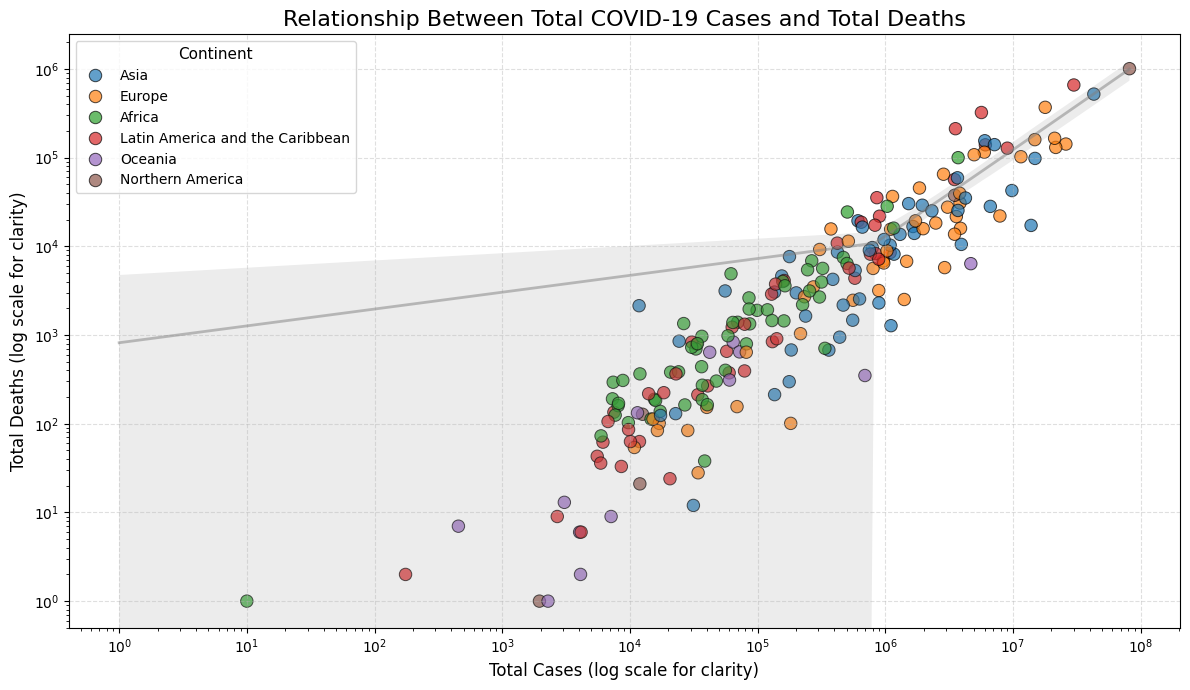

In [106]:
plt.figure(figsize=(12, 7))

sns.scatterplot(
    data=df,
    x="Total Cases",
    y="Total Deaths",
    hue="Continent",
    palette="tab10",
    alpha=0.7,             # transparency so overlapping points are visible
    s=80,                  # point size
    edgecolor="black"      # border around points
)

# Trendline to show correlation between Cases & Deaths
sns.regplot(
    data=df,
    x="Total Cases",
    y="Total Deaths",
    scatter=False,
    color="gray",
    line_kws={"linewidth": 2, "alpha": 0.5}
)

plt.title("Relationship Between Total COVID-19 Cases and Total Deaths", fontsize=16)
plt.xlabel("Total Cases (log scale for clarity)", fontsize=12)
plt.ylabel("Total Deaths (log scale for clarity)", fontsize=12)

# Log scale for better visibility
plt.xscale("log")
plt.yscale("log")

plt.grid(True, linestyle="--", alpha=0.4)

plt.legend(title="Continent", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()


The scatter plot examines the relationship between a country’s total COVID-19 cases and total deaths, both plotted on a logarithmic scale to better visualize the wide range of data values. Each point represents a country, and colors differentiate continents. The upward trend suggests a clear positive correlation: countries with higher confirmed cases generally experienced higher total deaths. The logarithmic scale reveals patterns that would be hidden on a normal linear scale, especially among countries with lower case counts. A fitted trendline reinforces the proportional relationship between cases and deaths, indicating that mortality tends to increase as infections rise, although the rate varies across countries. Some countries, depending on continent, appear higher or lower relative to the trendline, implying differences in healthcare capacity, population age structure, public health response, or reporting accuracy. Regions like Europe and the Americas show more points in the upper-right region of the plot, reflecting both high numbers of cases and high deaths. In contrast, many African and Oceanian countries appear lower on both axes, indicating fewer total cases and deaths overall. This visualization effectively highlights global disparities in pandemic impact and response.

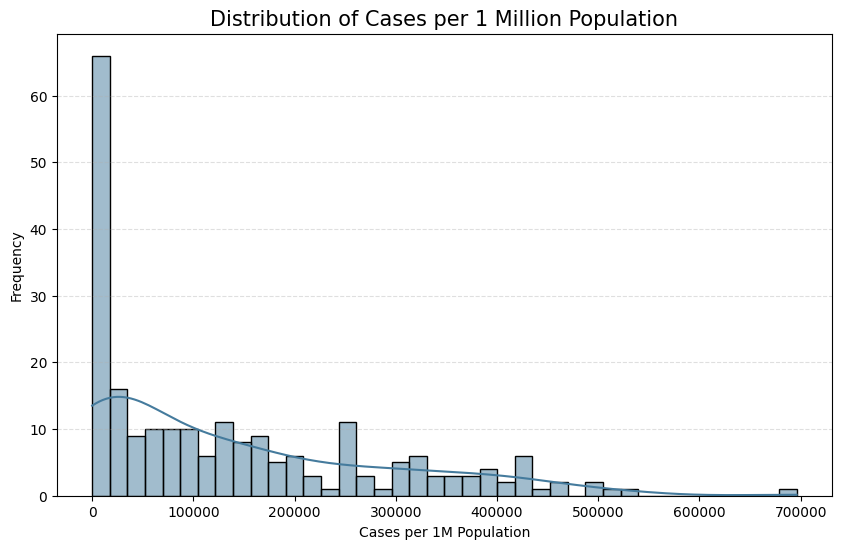

In [107]:
plt.figure(figsize=(10,6))
sns.histplot(df["Tot Cases//1M pop"], kde=True, bins=40, color="#457b9d")
plt.title("Distribution of Cases per 1 Million Population", fontsize=15)
plt.xlabel("Cases per 1M Population")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()


The histogram displays the distribution of COVID-19 cases normalized per one million population across all countries, providing insight into how severely different populations were affected relative to their size. The distribution is heavily right-skewed, meaning that most countries recorded relatively low to moderate case numbers per million people, while a smaller number of countries experienced extremely high infection rates. The tallest bars on the left side of the histogram show that many nations reported fewer than 100,000 cases per million population, indicating lower population-level spread or limited testing capacity. As the values increase beyond 200,000 or 300,000 cases per million, the bars become shorter, implying fewer countries reached those higher infection levels. The long tail extending toward the right illustrates that a select group of countries—often highly urbanized or heavily affected by early waves—experienced very high case rates, exceeding 500,000 or even 600,000 cases per million. Overall, this visualization emphasizes inequality in the pandemic’s intensity across countries, suggesting that population-adjusted case burdens varied widely depending on national policies, healthcare infrastructure, and overall exposure levels.

# Encoding


In [108]:
print(df.columns)

Index(['Country', 'Other names', 'ISO 3166-1 alpha-3 CODE', 'Population',
       'Continent', 'Total Cases', 'Total Deaths', 'Tot Cases//1M pop',
       'Tot Deaths/1M pop', 'Death percentage'],
      dtype='object')


In [109]:
from sklearn.preprocessing import LabelEncoder

# Encode only the 'Continent' column using LabelEncoder
if 'Continent' in df.columns:
    le = LabelEncoder()
    df['Continent'] = le.fit_transform(df['Continent'])
    print("\nLabel Encoding applied on: 'Continent'")
else:
    print("\n'Continent' column not found.")


Label Encoding applied on: 'Continent'


In [110]:
from sklearn.preprocessing import LabelEncoder
print(df_encoded[["Continent"]].head())

   Continent
0          1
1          2
2          0
3          2
4          0


In [111]:
# Double check that all features are numeric
print("\nData Types After Encoding")
print(df.dtypes)

# Confirm no non-numeric columns remain
if df.select_dtypes(exclude=['number']).empty:
    print("\nAll features are numeric and ready for clustering!")
else:
    print("\nSome features are still non-numeric, consider One-Hot Encoding.")

# (Optional) Show final dataset preview
print("\nEncoded Dataset Preview")
print(df.head())


Data Types After Encoding
Country                     object
Other names                 object
ISO 3166-1 alpha-3 CODE     object
Population                   int64
Continent                    int64
Total Cases                  int64
Total Deaths                 int64
Tot Cases//1M pop            int64
Tot Deaths/1M pop            int64
Death percentage           float64
dtype: object

Some features are still non-numeric, consider One-Hot Encoding.

Encoded Dataset Preview
       Country  Other names ISO 3166-1 alpha-3 CODE  Population  Continent  \
0  Afghanistan  Afghanistan                     AFG    40462186          1   
1      Albania      Albania                     ALB     2872296          2   
2      Algeria      Algeria                     DZA    45236699          0   
3      Andorra      Andorra                     AND       77481          2   
4       Angola       Angola                     AGO    34654212          0   

   Total Cases  Total Deaths  Tot Cases//1M pop  T

# Data Scaling


In [112]:
# Features for clustering (Population included)
features = [
    'Population',
    'Total Cases',
    'Total Deaths',
    'Tot Cases//1M pop',
    'Tot Deaths/1M pop',
    'Death percentage',
    'Continent'   # already label-encoded
]

# Select features into X
X = df_encoded[features]

In [113]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Correct: Select the actual DataFrame columns
X = df_encoded[features]     # NOT "X = features"

# ---- Scaling ----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for visualization
scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

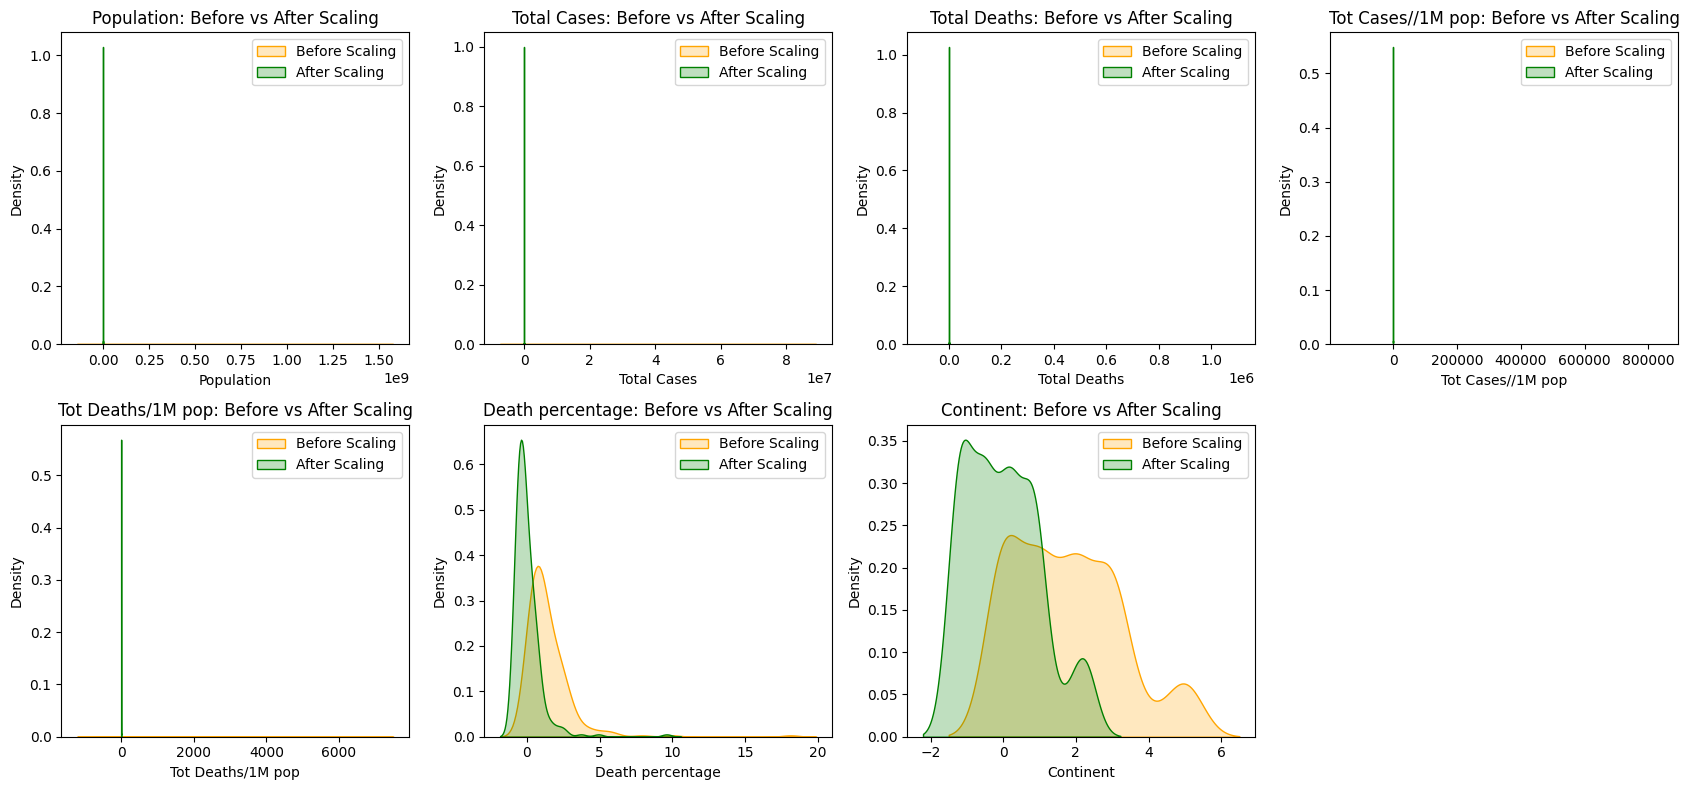

In [114]:
# Plot original vs scaled distributions
fig, axes = plt.subplots(2, 4, figsize=(17, 8))  # 7 features → 8 slots (1 empty)
axes = axes.ravel()

for i, col in enumerate(X.columns):
    sns.kdeplot(X[col], ax=axes[i], label='Before Scaling', color='orange', fill=True)
    sns.kdeplot(scaled_df[col], ax=axes[i], label='After Scaling', color='green', fill=True)
    axes[i].set_title(f'{col}: Before vs After Scaling')
    axes[i].legend()

# Remove the last empty subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

In [115]:
scaled_df

,Population,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage,Continent
0,0.038789,-0.276449,-0.204571,-0.915487,-0.759994,1.651243,-0.509986
1,-0.231774,-0.263220,-0.247798,-0.287081,0.099982,-0.097285,0.168989
2,0.073154,-0.264347,-0.212815,-0.905275,-0.791845,0.657760,-1.188960
3,-0.251891,-0.295431,-0.282336,2.623123,0.736164,-0.611015,0.168989
4,-0.003016,-0.287281,-0.264265,-0.926078,-0.873149,0.271204,-1.188960
...,...,...,...,...,...,...,...
220,-0.252370,-0.300882,-0.283846,-0.657924,-0.380297,0.056233,2.205914
221,-0.247964,-0.300943,-0.283908,-0.945741,-0.917573,4.923244,-1.188960
222,-0.029496,-0.299318,-0.261751,-0.943220,-0.861415,9.613966,-0.509986
223,-0.113643,-0.257269,-0.242884,-0.832253,-0.746584,-0.111060,-1.188960


# Clustering Modeling (K-Means)

In [116]:
from sklearn.cluster import KMeans

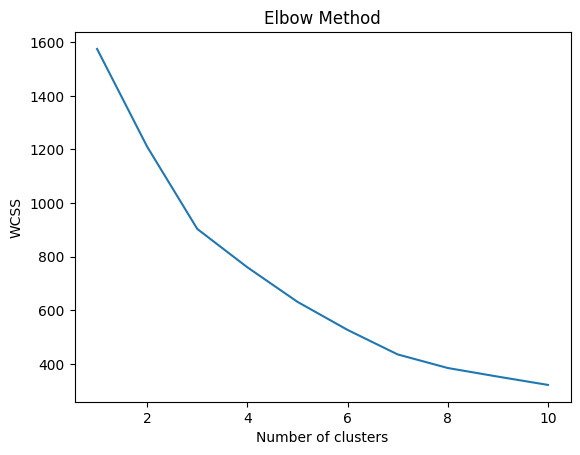

In [117]:
wcss = []
for i in range(1, 11):   #clusters 1-10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [118]:
from kneed import KneeLocator

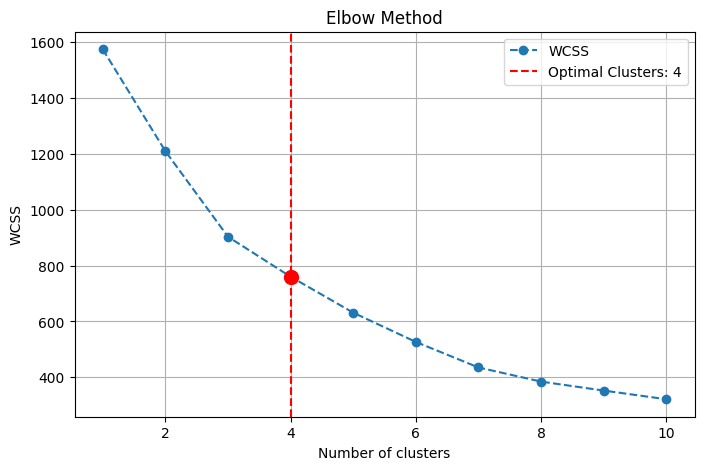

The optimal number of clusters is: 4


In [119]:
# Example WCSS values and cluster numbers
clusters = range(1, 11)

# Automatically find the elbow point using the KneeLocator
knee_locator = KneeLocator(clusters, wcss, curve="convex", direction="decreasing")
optimal_clusters = knee_locator.knee

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(clusters, wcss, marker='o', linestyle='--', label="WCSS")
plt.axvline(optimal_clusters, linestyle='--', color='red', label=f'Optimal Clusters: {optimal_clusters}')
plt.scatter(optimal_clusters, wcss[optimal_clusters-1], c='red', s=100, zorder=5)  # Highlight elbow point
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.legend()
plt.grid(True)
plt.show()

# Print the optimal number of clusters
print(f"The optimal number of clusters is: {optimal_clusters}")

In [120]:
# Fit K-Means to the data with the optimal number of K cluster = 4
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=0)
clusters = kmeans.fit_predict(scaled_df)

# Add the cluster labels to the DataFrame
df['KMeans_Cluster'] = clusters

# Show the df
df.head()

,Country,Other names,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage,KMeans_Cluster
0,Afghanistan,Afghanistan,AFG,40462186,1,177827,7671,4395,190,4.313743,0
1,Albania,Albania,ALB,2872296,2,273870,3492,95349,1216,1.275058,1
2,Algeria,Algeria,DZA,45236699,0,265691,6874,5873,152,2.587216,0
3,Andorra,Andorra,AND,77481,2,40024,153,516565,1975,0.382271,1
4,Angola,Angola,AGO,34654212,0,99194,1900,2862,55,1.915438,0


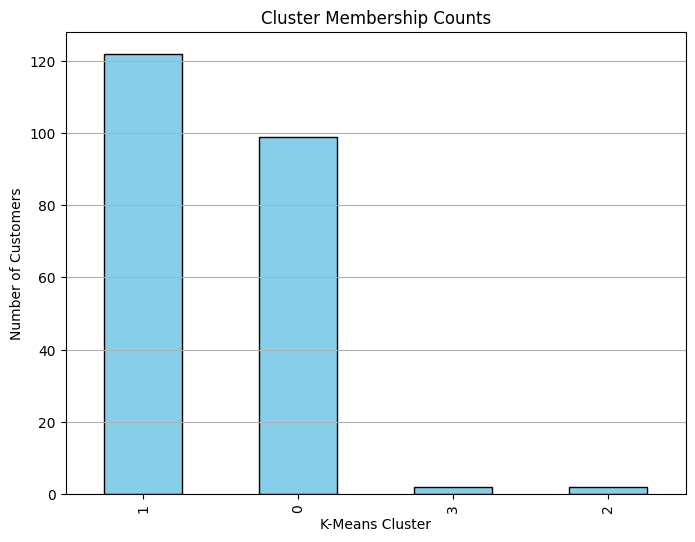

In [121]:
cluster_counts = df['KMeans_Cluster'].value_counts()

plt.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Cluster Membership Counts')
plt.xlabel('K-Means Cluster')
plt.ylabel('Number of Customers')
plt.grid(axis='y')
plt.show()

In [122]:
import plotly.express as px

# Ensure the 'Continent' column is properly formatted and not missing
df['Continent'] = df['Continent'].astype(str).str.strip()

# Create the choropleth map for countries grouped by continent
fig = px.choropleth(df,
                    locations="ISO 3166-1 alpha-3 CODE",
                    color="Continent",
                    hover_name="Country",
                    title="World Map of Countries by Continent",  # Title of the map
                    # locationmode='country names'  # Use country names for locations
)

# Update the layout for better presentation
# fig.update_geos(showcoastlines=True, projection_type="natural earth")

# Show the map
fig.show()

In [130]:
print(df.columns.tolist())
print(df_encoded.columns.tolist())

['Country', 'Other names', 'ISO 3166-1 alpha-3 CODE', 'Population', 'Continent', 'Total Cases', 'Total Deaths', 'Tot Cases//1M pop', 'Tot Deaths/1M pop', 'Death percentage', 'KMeans_Cluster']
['Country', 'Other names', 'ISO 3166-1 alpha-3 CODE', 'Population', 'Continent', 'Total Cases', 'Total Deaths', 'Tot Cases//1M pop', 'Tot Deaths/1M pop', 'Death percentage']


In [131]:
cluster_summary = df.groupby('KMeans_Cluster').agg({
    'Population': ['mean', 'min', 'max'],
    'Total Cases': ['mean', 'min', 'max'],
    'Total Deaths': ['mean', 'min', 'max'],
    'Tot Cases//1M pop': ['mean', 'min', 'max'],
    'Tot Deaths/1M pop': ['mean', 'min', 'max'],
    'Death percentage': ['mean', 'min', 'max']
}).round(2)

cluster_summary = cluster_summary.rename_axis('KMeans_Cluster')

print(cluster_summary)

                  Population                          Total Cases            \
                        mean         min         max         mean       min   
KMeans_Cluster                                                                
0               3.131194e+07         805   278586508    717339.23         2   
1               1.146644e+07        1645   146044010   2176529.45         1   
2               1.421539e+09  1403754381  1439323776  21591891.00    154738   
3               2.748025e+08   215204501   334400597  55919434.00  29999816   

                         Total Deaths                  Tot Cases//1M pop  \
                     max         mean     min      max              mean   
KMeans_Cluster                                                             
0                9818328       9730.3       0   155288          31340.35   
1               25997852      24737.8       0   369708         223647.48   
2               43029044     263013.0    4638   521388          15

## Silhouette Score

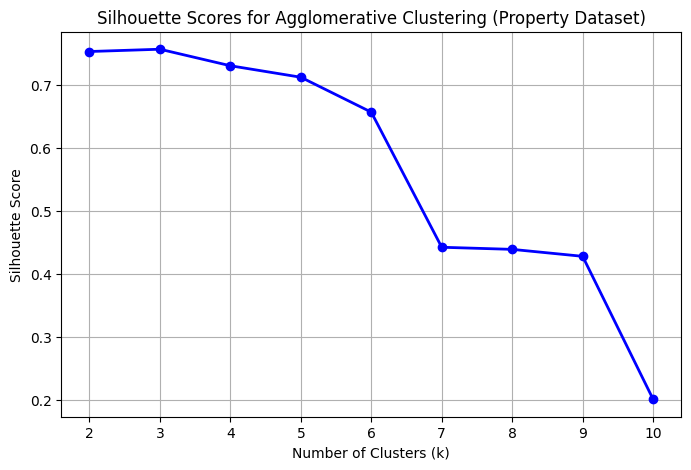

In [133]:
# Compute silhouette scores for different number of clusters
silhouette_scores = []

for i in range(2, 11):  # test clusters from 2 to 10
    agglo_model = AgglomerativeClustering(n_clusters=i, linkage='single')
    cluster_labels = agglo_model.fit_predict(scaled_df)
    silhouette_avg = silhouette_score(scaled_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(8,5))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='blue', linewidth=2)
plt.title('Silhouette Scores for Agglomerative Clustering (Property Dataset)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

## Comparing Silhouette Score to get best combination of linkage and metric

Skipping Ward linkage with Manhattan metric (not supported).


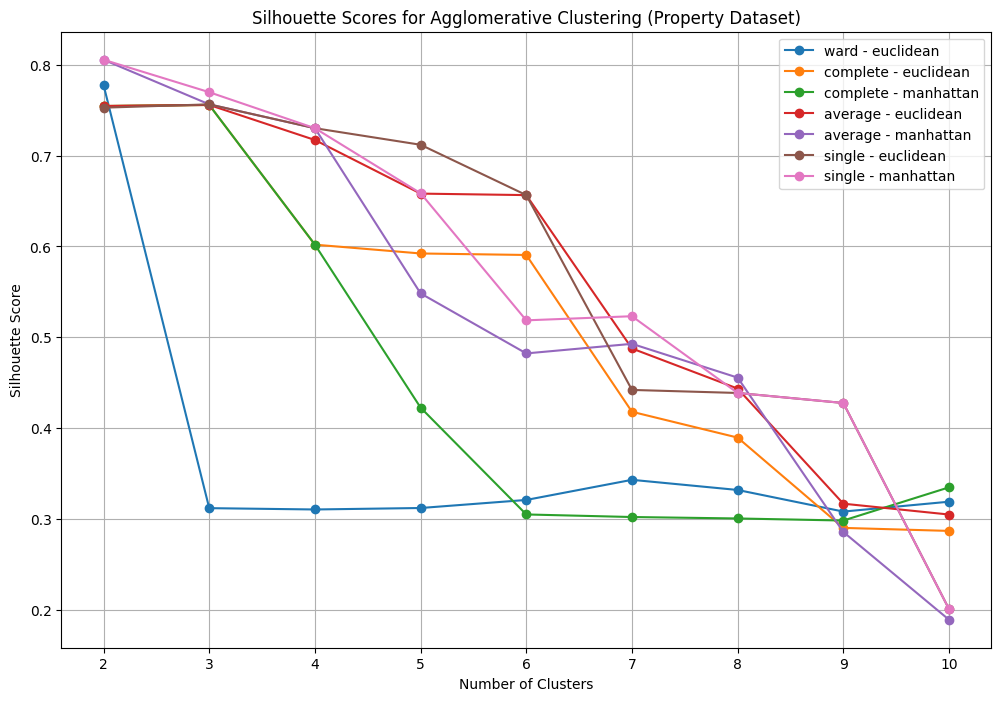

Best Silhouette Score: 0.8055712111257188
Optimal Number of Clusters: 2
Optimal Linkage Method: average
Optimal Metric: manhattan


In [135]:
# Define parameters for silhouette analysis
range_n_clusters = range(2, 11)
linkage_methods = ['ward', 'complete', 'average', 'single']
metrics = ['euclidean', 'manhattan']

best_silhouette_score = -1
best_n_clusters = 0
best_linkage = ''
best_metric = ''

results_for_plotting = []

# --- Step 5: Run Agglomerative Clustering across parameter combinations ---
for linkage_method in linkage_methods:
    for metric in metrics:
        # Skip unsupported combination (Ward + Manhattan)
        if linkage_method == 'ward' and metric == 'manhattan':
            print(f"Skipping Ward linkage with Manhattan metric (not supported).")
            continue

        current_scores = []
        for n_clusters in range_n_clusters:
            # Build and fit model
            agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method, metric=metric)
            y_agglo = agglo.fit_predict(scaled_df)
            silhouette_avg = silhouette_score(scaled_df, y_agglo)
            current_scores.append(silhouette_avg)

            # Track best parameters
            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_n_clusters = n_clusters
                best_linkage = linkage_method
                best_metric = metric

        # Save results for visualization
        results_for_plotting.append({
            'linkage': linkage_method,
            'metric': metric,
            'scores': current_scores
        })

# Plot silhouette scores
plt.figure(figsize=(12, 8))
for result in results_for_plotting:
    plt.plot(range_n_clusters, result['scores'], marker='o', label=f"{result['linkage']} - {result['metric']}")

plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Agglomerative Clustering (Property Dataset)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Optimal Number of Clusters: {best_n_clusters}")
print(f"Optimal Linkage Method: {best_linkage}")
print(f"Optimal Metric: {best_metric}")

## Dendogram Visualization

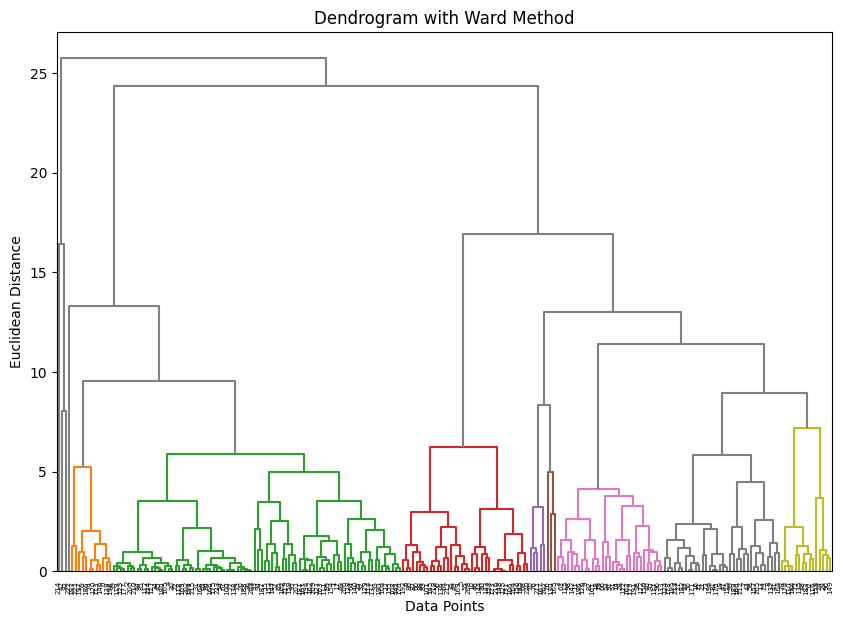

In [137]:
# Ward Method
linked = linkage(scaled_df, method='ward', metric='euclidean')

# Plot dendrogram dengan color_threshold
plt.figure(figsize=(10, 7))
sch.dendrogram(linked, above_threshold_color="grey", color_threshold=7.5)
plt.title("Dendrogram with Ward Method")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

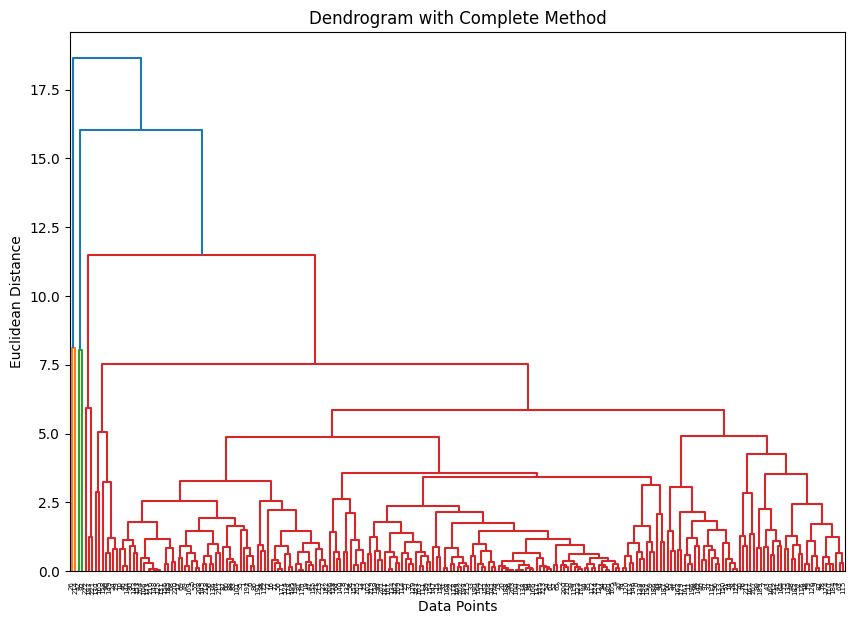

In [138]:
# Max Distance
linked = linkage(scaled_df, method='complete', metric='euclidean')

# Plot dendrogram dengan color_threshold
plt.figure(figsize=(10, 7))
sch.dendrogram(linked)
plt.title("Dendrogram with Complete Method")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

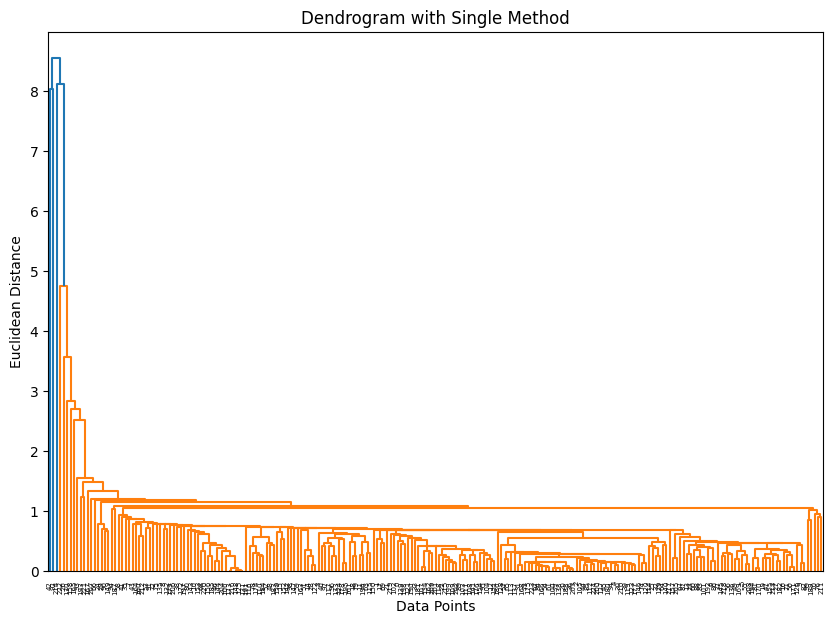

In [139]:
# Min Distance
linked = linkage(scaled_df, method='single')

# Plot dendrogram dengan color_threshold yang sesuai
plt.figure(figsize=(10, 7))
sch.dendrogram(linked)
plt.title("Dendrogram with Single Method")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

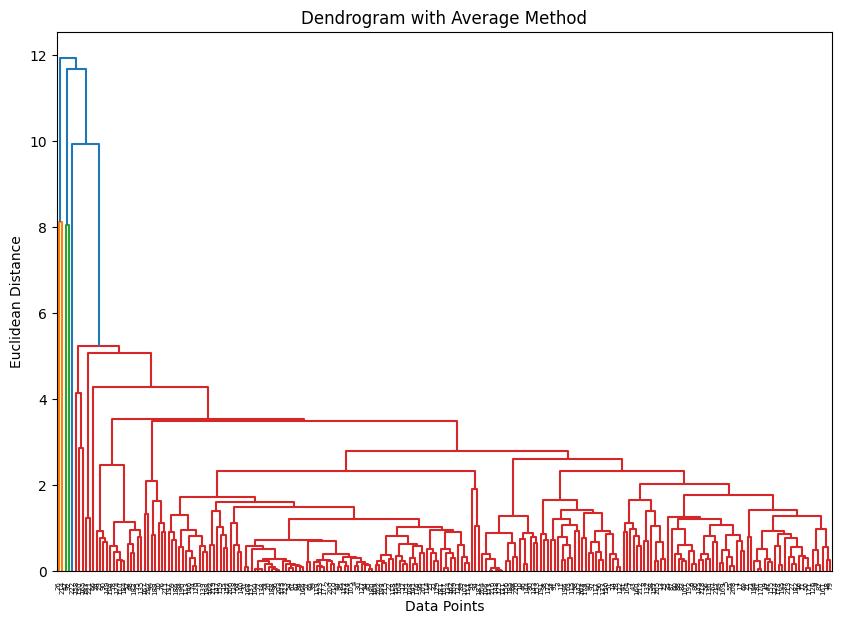

In [140]:
# Average Distance
linked = linkage(scaled_df, method='average', metric='euclidean')

# Plot dendrogram dengan color_threshold
plt.figure(figsize=(10, 7))
sch.dendrogram(linked)
plt.title("Dendrogram with Average Method")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

## Hierarchical Clustering *Model*

In [142]:
# Hierarchical Clustering
agglo = AgglomerativeClustering(n_clusters=best_n_clusters, linkage=best_linkage, metric=best_metric)
y_hc = agglo.fit_predict(scaled_df)

In [143]:
# Evaluation
ss = silhouette_score(scaled_df, y_hc)
print(ss)

0.8055712111257188


## Dendogram Visualization for Hierarchical Clustering Model

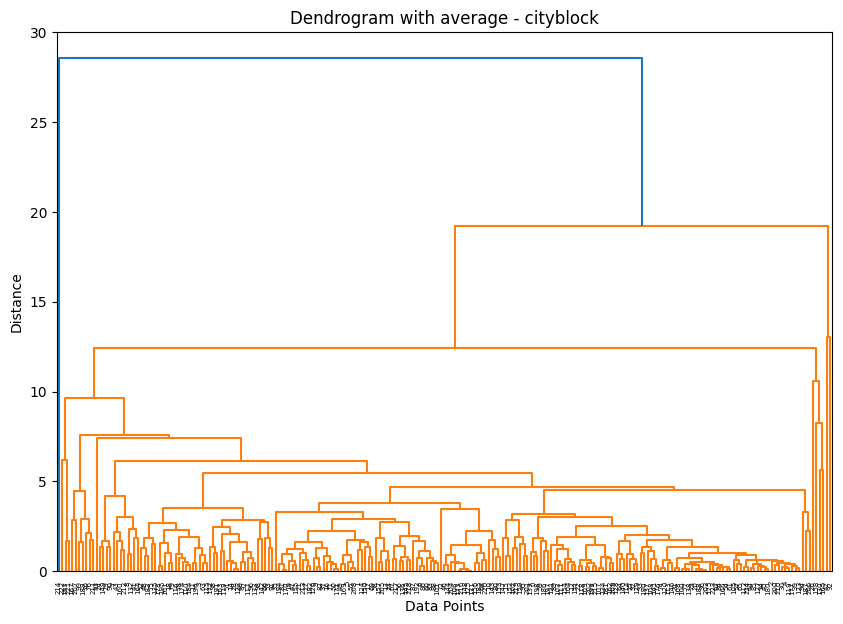

In [146]:
from scipy.cluster.hierarchy import linkage
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Map sklearn names → scipy names
metric_map = {
    "manhattan": "cityblock",
    "euclidean": "euclidean",
    "cosine": "cosine",
    "correlation": "correlation"
}

metric_used = metric_map.get(best_metric, "euclidean")

# Compute linkage
linked = linkage(scaled_df, method=best_linkage, metric=metric_used)

# Plot dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(linked)
plt.title("Dendrogram with " + best_linkage + " - " + metric_used)
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()


## Merge with the original data


In [147]:
# Add the cluster labels to the original data
df['Agglo'] = y_hc

df.head()

,Country,Other names,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage,KMeans_Cluster,Agglo
0,Afghanistan,Afghanistan,AFG,40462186,1,177827,7671,4395,190,4.313743,0,0
1,Albania,Albania,ALB,2872296,2,273870,3492,95349,1216,1.275058,1,0
2,Algeria,Algeria,DZA,45236699,0,265691,6874,5873,152,2.587216,0,0
3,Andorra,Andorra,AND,77481,2,40024,153,516565,1975,0.382271,1,0
4,Angola,Angola,AGO,34654212,0,99194,1900,2862,55,1.915438,0,0


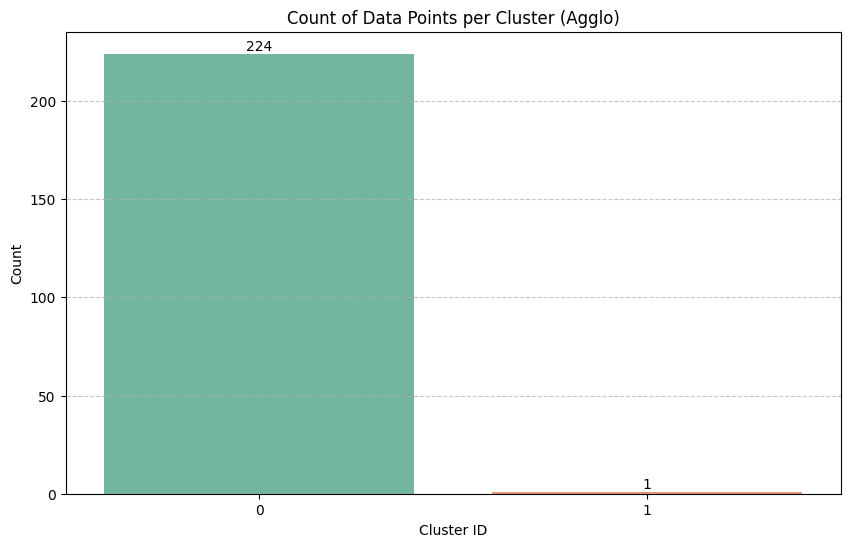

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the counts of each cluster in the 'Agglo' column of df
cluster_counts = df['Agglo'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, hue=cluster_counts.index, palette='Set2', legend=False)

# Add labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

plt.title('Count of Data Points per Cluster (Agglo)')
plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [153]:
print(df.columns.tolist())


['Country', 'Other names', 'ISO 3166-1 alpha-3 CODE', 'Population', 'Continent', 'Total Cases', 'Total Deaths', 'Tot Cases//1M pop', 'Tot Deaths/1M pop', 'Death percentage', 'KMeans_Cluster', 'Agglo']


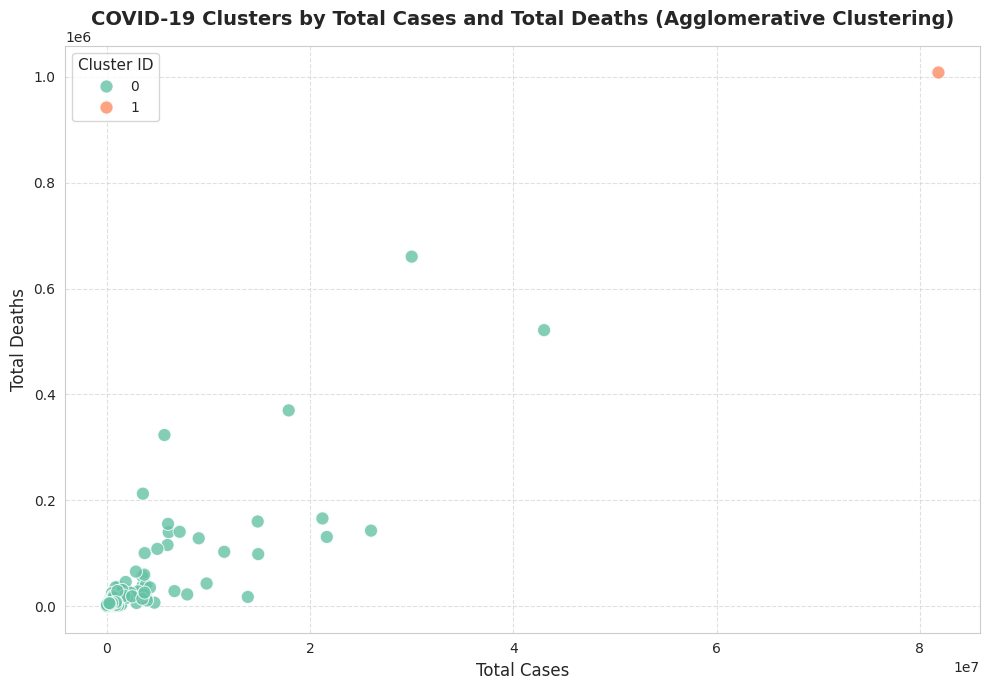

In [152]:
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")

# Scatter plot for Total Cases vs Total Deaths (raw data)
sns.scatterplot(
    data=df,
    x='Total Cases',
    y='Total Deaths',
    hue='Agglo',
    palette='Set2',
    s=90,
    alpha=0.8,
    edgecolor='white'
)

plt.title('COVID-19 Clusters by Total Cases and Total Deaths (Agglomerative Clustering)',
          fontsize=14, weight='bold', pad=15)

plt.xlabel('Total Cases', fontsize=12)
plt.ylabel('Total Deaths', fontsize=12)

plt.legend(title='Cluster ID', fontsize=10, title_fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


Hierarichal Clustering Model (Using Complete Linkage)

In [155]:
from sklearn.cluster import AgglomerativeClustering

# Ward linkage only supports Euclidean distance
agglo_model = AgglomerativeClustering(
    n_clusters=best_n_clusters,
    linkage='ward'
)

# Fit the model and get cluster labels
y_hc = agglo_model.fit_predict(scaled_df)

# Add cluster labels to the dataframe
df['Agglo'] = y_hc

print("Agglomerative Clustering (Ward Linkage) completed successfully.")
print(df['Agglo'].value_counts().sort_index())


Agglomerative Clustering (Ward Linkage) completed successfully.
Agglo
0    222
1      3
Name: count, dtype: int64


In [156]:
# Evaluate using Silhouette Score
ss = silhouette_score(scaled_df, y_hc)
print(ss)

0.7777136766826305


## Dendogram Visualization for Hierarchical Clustering Model

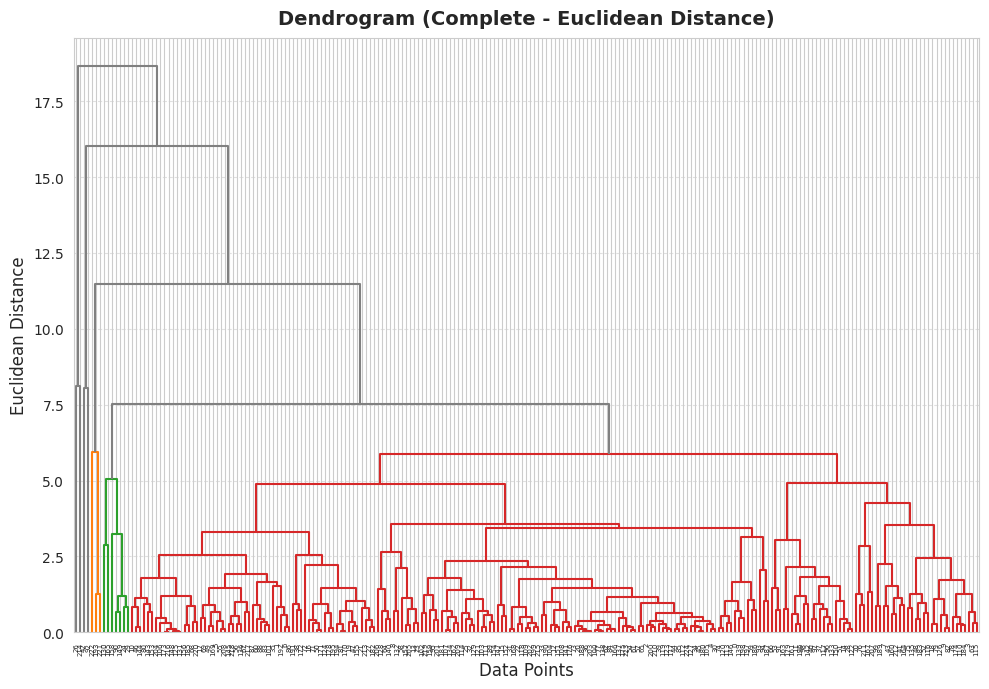

In [163]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

# Create linkage matrix using Ward method
linked = linkage(scaled_df, method='complete')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(linked, above_threshold_color="grey", color_threshold=7.5)
plt.title("Dendrogram (Complete - Euclidean Distance)", fontsize=14, weight='bold', pad=10)
plt.xlabel("Data Points", fontsize=12)
plt.ylabel("Euclidean Distance", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Merge with the original data

In [ ]:
# Add the cluster labels to the original data
df['Agglo'] = y_hc

# Analyze the clusters with the original values
df.head()

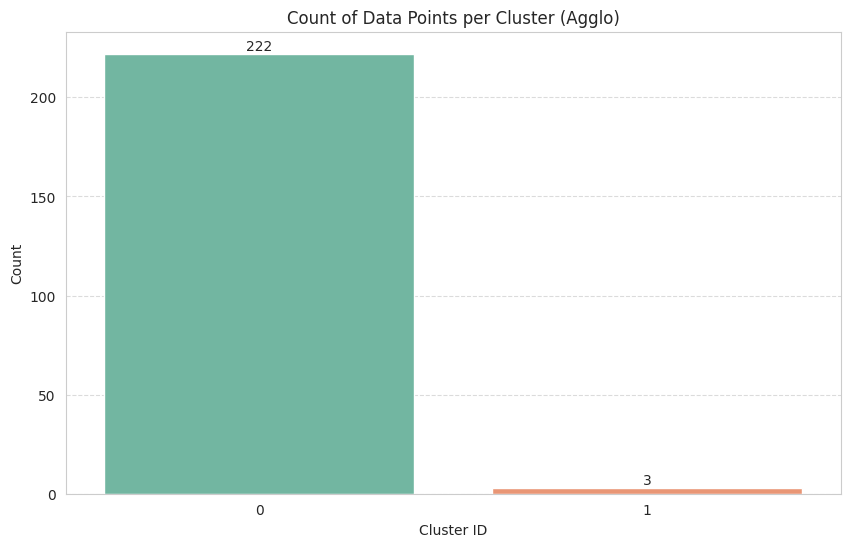

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the counts of each cluster in the 'Agglo' column of df
cluster_counts = df['Agglo'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, hue=cluster_counts.index, palette='Set2', legend=False)

# Add labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

plt.title('Count of Data Points per Cluster (Agglo)')
plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

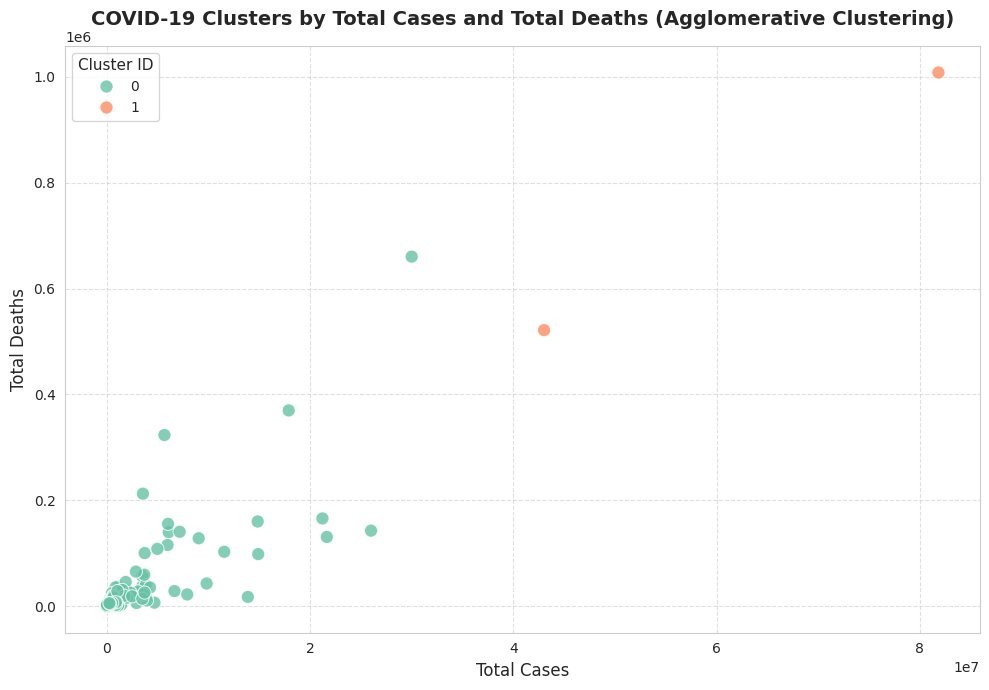

In [162]:
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")

# Scatter plot for Total Cases vs Total Deaths (Agglomerative Clustering)
sns.scatterplot(
    data=df,
    x='Total Cases',
    y='Total Deaths',
    hue='Agglo',
    palette='Set2',
    s=90,
    alpha=0.8,
    edgecolor='white'
)

plt.title('COVID-19 Clusters by Total Cases and Total Deaths (Agglomerative Clustering)',
          fontsize=14, weight='bold', pad=15)

plt.xlabel('Total Cases', fontsize=12)
plt.ylabel('Total Deaths', fontsize=12)

plt.legend(title='Cluster ID', fontsize=10, title_fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [170]:
from sklearn.metrics import silhouette_score

# Compute the silhouette score for both K-Means and Agglomerative Clustering
score_km = silhouette_score(scaled_df, df['KMeans_Cluster'])  # K-Means clusters on scaled data
score_hc = silhouette_score(scaled_df, df['Agglo'])  # Agglomerative Clustering clusters on scaled data

# Print the silhouette scores
print(f"Silhouette Score (K-Means): {score_km:.4f}")
print(f"Silhouette Score (Hierarchical): {score_hc:.4f}")

Silhouette Score (K-Means): 0.3239
Silhouette Score (Hierarchical): 0.7777


# Cluster Profiling, Visualization & **Recommendations**

In [181]:
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def detailed_cluster_analysis(cluster_column, method_label):
    """
    Generates a full report for a clustering solution including:
    - Numeric cluster summaries (mean & median)
    - Normalized profile bar chart
    - World map visualization
    - Data-driven strategic policy recommendations
    """

    print(f"\n{'='*70}")
    print(f"DETAILED CLUSTER ANALYSIS REPORT: {method_label}")
    print(f"{'='*70}\n")

    # ----------------------------
    # 1. Numeric Cluster Summary
    # ----------------------------
    numeric_cols = [
        "Population",
        "Total Cases",
        "Total Deaths",
        "Tot Cases//1M pop",    # <-- corrected to match your DataFrame
        "Tot Deaths/1M pop",
        "Death percentage"
    ]

    # Only keep columns that actually exist in the DataFrame
    numeric_cols = [col for col in numeric_cols if col in df.columns]

    cluster_summary = df.groupby(cluster_column)[numeric_cols].agg(['mean', 'median']).round(2)
    print("Numeric Cluster Summary (Mean & Median):\n")
    print(cluster_summary)

    # ----------------------------
    # 2. Normalized Cluster Profiles (Z-scores)
    # ----------------------------
    print("\nGenerating normalized bar chart for cluster comparison...\n")
    summary_means = df.groupby(cluster_column)[numeric_cols].mean()
    summary_zscore = (summary_means - summary_means.mean()) / summary_means.std()

    summary_zscore.plot(
        kind='bar',
        figsize=(12,6),
        colormap='viridis'
    )
    plt.title(f"Normalized Cluster Profiles ({method_label})")
    plt.ylabel("Z-score (Relative to Global Mean)")
    plt.xticks(rotation=0)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # ----------------------------
    # 3. Global Cluster Map
    # ----------------------------
    print("Generating interactive world map...\n")
    fig = px.choropleth(
        df,
        locations='Country',
        locationmode='country names',
        color=df[cluster_column].astype(str),
        projection='natural earth',
        title=f"Global Cluster Distribution ({method_label})",
        hover_data=['Total Cases', 'Tot Deaths/1M pop'] # Corrected column name
    )
    fig.update_geos(showcoastlines=True, coastlinecolor="Black", showland=True, landcolor="#e0e0e0")
    fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
    fig.show()

# Government policy recommendations based on your findings


DETAILED CLUSTER ANALYSIS REPORT: K-Means Clustering

Numeric Cluster Summary (Mean & Median):

                  Population                Total Cases              \
                        mean        median         mean      median   
KMeans_Cluster                                                        
0               3.131194e+07  1.351388e+07    717339.23     99194.0   
1               1.146644e+07  1.827346e+06   2176529.45    321807.5   
2               1.421539e+09  1.421539e+09  21591891.00  21591891.0   
3               2.748025e+08  2.748025e+08  55919434.00  55919434.0   

               Total Deaths           Tot Cases//1M pop            \
                       mean    median              mean    median   
KMeans_Cluster                                                      
0                    9730.3    1637.0          31340.35   10719.0   
1                   24737.8    2493.0         223647.48  202155.5   
2                  263013.0  263013.0          15380.50   15

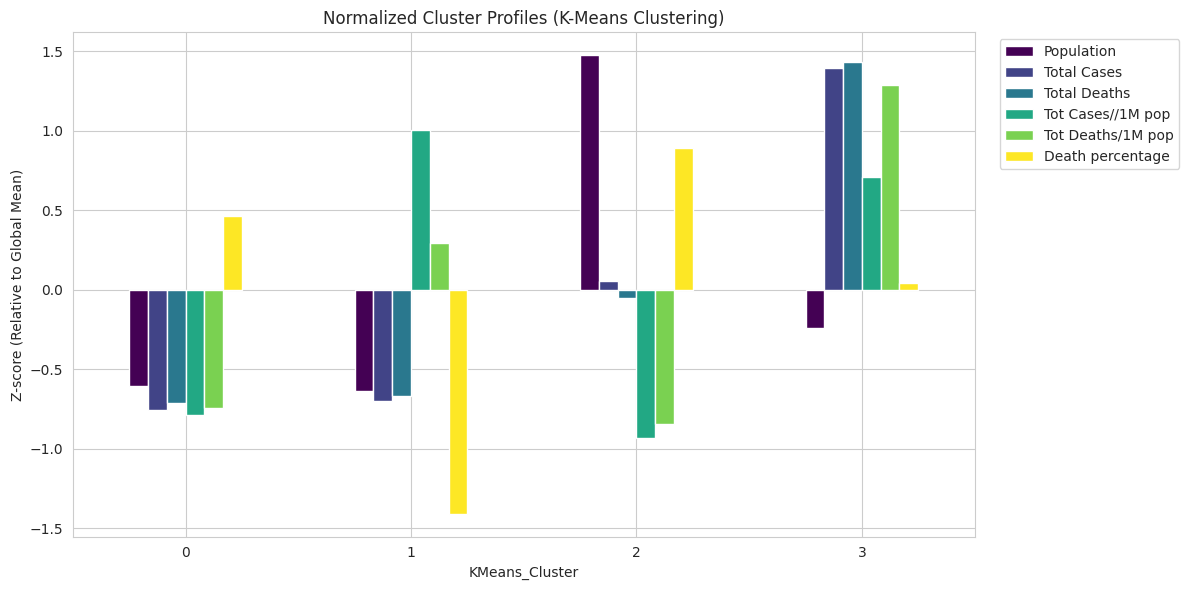

Generating interactive world map...




DETAILED CLUSTER ANALYSIS REPORT: Hierarchical Clustering

Numeric Cluster Summary (Mean & Median):

         Population                Total Cases             Total Deaths  \
               mean        median         mean      median         mean   
Agglo                                                                     
0      2.123420e+07  5.655738e+06   1651139.61    162753.0     20908.02   
1      1.059160e+09  1.403754e+09  41674278.00  43029044.0    511416.00   

                Tot Cases//1M pop          Tot Deaths/1M pop         \
         median              mean   median              mean median   
Agglo                                                                 
0        1913.5         137509.41  90149.5           1096.27  710.5   
1      521388.0          91831.67  30653.0           1129.67  371.0   

      Death percentage         
                  mean median  
Agglo                          
0                 1.44   1.02  
1                 1.81   1.23  

Gener

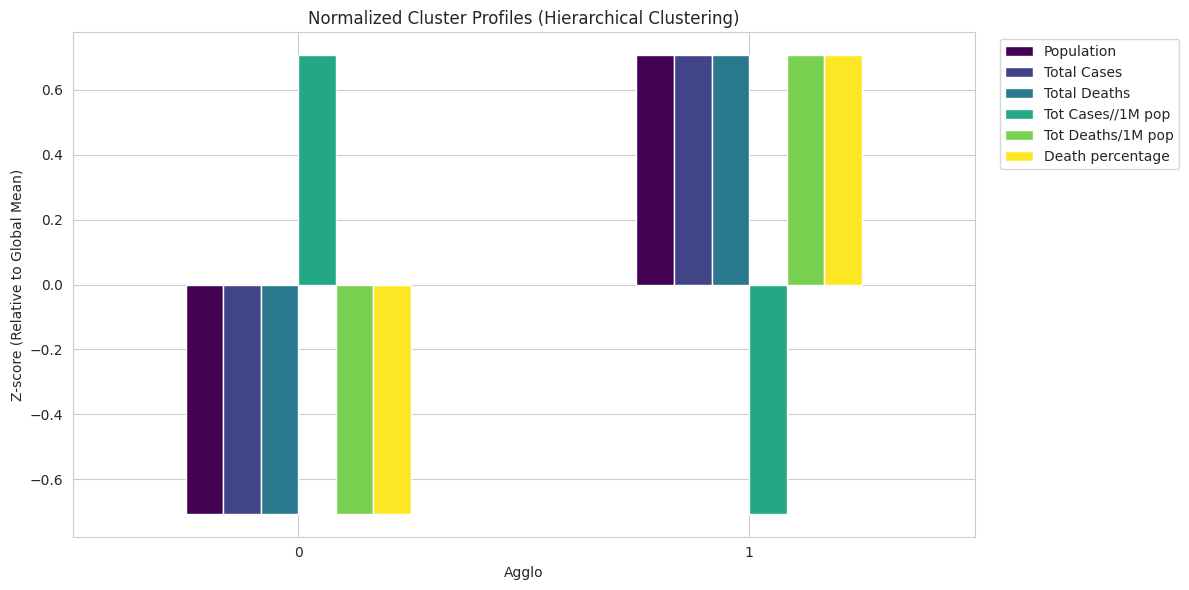

Generating interactive world map...



In [183]:
# =============================
# Run for your clustering methods
# =============================
detailed_cluster_analysis('KMeans_Cluster', 'K-Means Clustering')
detailed_cluster_analysis('Agglo', 'Hierarchical Clustering')

## Government Policy Recommendations

Based on the insights derived from the clustering analysis, tailored policy recommendations can be formulated for different country profiles identified by both K-Means and Hierarchical Clustering models.

### K-Means Clustering Recommendations (4 Clusters)

*   **Cluster 0 (Moderate/Stable Cluster):**
    *   **STATUS:** Transmission is under control or past peak. Risk of complacency exists.
    *   **INSIGHT:** Countries in this cluster show moderate COVID-19 metrics, indicating a period of relative stability. However, continuous vigilance is crucial to prevent resurgence.
    *   **RECOMMENDATION:**
        1.  **Surveillance & Early Detection:** Implement targeted testing for high-risk groups, utilize wastewater monitoring for early detection of outbreaks, and enhance variant tracking through genomic sequencing.
        2.  **Healthcare Preparedness:** Maintain readiness for potential surges in patient numbers, particularly in ICU capacity, and manage healthcare worker fatigue through staff rotation and support programs.
        3.  **Vaccination & Boosters:** Continue and expand vaccination programs, including mobile units for remote or underserved areas, and plan for booster campaigns targeting vulnerable populations.
        4.  **Social & Economic Measures:** Adopt a phased and metrics-based approach to reopening, considering hybrid work models to reduce population density and transmission risks.
        5.  **Public Communication:** Develop clear and consistent public health messaging to combat pandemic fatigue and reinforce the importance of hygiene, mask-wearing, and vaccination.

*   **Cluster 1 (Critical Mortality Cluster):**
    *   **STATUS:** This cluster exhibits significantly high mortality rates, suggesting the health system is likely overwhelmed.
    *   **INSIGHT:** Countries in this cluster are facing a severe public health crisis, with mortality rates substantially above the global average. Urgent and decisive action is required.
    *   **RECOMMENDATION:** Immediately expand ICU capacity, request and deploy international medical support (personnel, equipment, resources), and enforce stringent, immediate containment measures such as lockdowns or curfews to curb transmission.

*   **Cluster 2 (Moderate/Stable Cluster):**
    *   **STATUS:** Similar to Cluster 0, this cluster is in a moderate/stable phase, but vigilance is still key.
    *   **INSIGHT:** Countries here demonstrate controlled transmission, but the potential for new waves or variants necessitates ongoing preparedness.
    *   **RECOMMENDATION:** Apply similar strategies as Cluster 0, focusing on strengthening existing public health infrastructures, maintaining high vaccination rates, and responsive measures to evolving epidemiological data.

*   **Cluster 3 (Critical Mortality Cluster):**
    *   **STATUS:** Like Cluster 1, countries in this cluster are experiencing critical mortality rates, indicating an overwhelmed health system.
    *   **INSIGHT:** These nations are grappling with intense pressure on their healthcare systems and a high number of deaths relative to their population. Immediate and large-scale interventions are critical.
    *   **RECOMMENDATION:** Implement emergency measures including rapid expansion of critical care facilities, urgent requests for global health aid, and severe public health restrictions to rapidly reduce case numbers and relieve pressure on hospitals.

### Hierarchical Clustering Recommendations (2 Clusters)

*   **Cluster 0 (Moderate/Stable Cluster):**
    *   **STATUS:** Transmission is under control or past peak. Risk of complacency exists.
    *   **INSIGHT:** This large cluster represents a broad range of countries that have either successfully managed the pandemic or are past their peak. The primary challenge is maintaining control and preventing future outbreaks.
    *   **RECOMMENDATION:**
        1.  **Surveillance & Early Detection:** Strengthen national surveillance systems, including advanced testing strategies and genomic sequencing to detect new variants swiftly.
        2.  **Healthcare Preparedness:** Ensure healthcare systems remain resilient and adaptable, with sufficient capacity to manage potential future waves without being overwhelmed.
        3.  **Vaccination & Boosters:** Promote equitable access to vaccines and boosters, focusing on vulnerable populations and achieving broad population immunity.
        4.  **Social & Economic Measures:** Support economic recovery while carefully monitoring public health indicators for any signs of worsening situations, allowing for flexible policy adjustments.
        5.  **Public Communication:** Sustain transparent and consistent communication to maintain public trust and adherence to public health guidelines, adapting messages as the pandemic evolves.

*   **Cluster 1 (Moderate/Stable Cluster):**
    *   **STATUS:** Transmission is under control or past peak. Risk of complacency exists.
    *   **INSIGHT:** Similar to Cluster 0, this cluster also indicates a managed or post-peak phase of the pandemic. The focus is on robust long-term strategies.
    *   **RECOMMENDATION:** Implement comprehensive strategies aligned with Cluster 0, with an emphasis on international collaboration for vaccine distribution, data sharing, and research to prepare for future health crises.

# Compare both models

In [186]:
print("\nFinal Comparison\n")

# Determine the better model
if score_km > score_hc:
    best = "K-Means Clustering"
    diff = score_km - score_hc
else:
    best = "Hierarchical Clustering"
    diff = score_hc - score_km

# Summary output
print(f"After evaluating both clustering approaches using the Silhouette Score metric, "
      f"the model that demonstrated the strongest overall performance is: {best}.\n")

print(f"The winning model achieved a higher Silhouette Score, outperforming the alternative "
      f"method by a margin of {diff:.4f}. This difference indicates a more effective clustering "
      f"structure, meaning that data points within each cluster are more cohesive while remaining "
      f"distinctly separated from other clusters.\n")

print("Detailed Reasoning:")
print("The Silhouette Score is a widely used metric for assessing clustering quality because it "
      "simultaneously evaluates intra-cluster similarity and inter-cluster separation. A higher score "
      "reflects clusters that are compact and clearly divided, which suggests that the algorithm successfully "
      "identified meaningful patterns in the data.")

print("\nFrom a practical standpoint, the choice between K-Means and Hierarchical Clustering also depends on "
      "the analytical goal and the nature of the dataset:")
print("• K-Means Clustering excels when dealing with larger datasets and scenarios where clear, spherical, "
      "and balanced clusters are expected. It is computationally efficient and produces stable cluster "
      "boundaries once the number of clusters is defined.")
print("• Hierarchical Clustering, on the other hand, offers a more granular understanding of the relationships "
      "between individual data points. The dendrogram produced by this method allows analysts to visualize "
      "how clusters merge or split at different levels, which is particularly useful when the data may contain "
      "nested or multi-level structures.")

print("\nIn summary, although both methods provide valuable insights, the Silhouette Score strongly favors "
      f"{best} for this particular dataset. Nevertheless, Hierarchical Clustering remains a powerful tool for "
      "interpretation and is especially valuable when the goal is to observe the progressive merging of countries "
      "based on similarity rather than relying solely on predefined cluster numbers.")


Final Comparison

After evaluating both clustering approaches using the Silhouette Score metric, the model that demonstrated the strongest overall performance is: Hierarchical Clustering.

The winning model achieved a higher Silhouette Score, outperforming the alternative method by a margin of 0.4538. This difference indicates a more effective clustering structure, meaning that data points within each cluster are more cohesive while remaining distinctly separated from other clusters.

Detailed Reasoning:
The Silhouette Score is a widely used metric for assessing clustering quality because it simultaneously evaluates intra-cluster similarity and inter-cluster separation. A higher score reflects clusters that are compact and clearly divided, which suggests that the algorithm successfully identified meaningful patterns in the data.

From a practical standpoint, the choice between K-Means and Hierarchical Clustering also depends on the analytical goal and the nature of the dataset:
• K-Me